In [111]:
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.stats import ttest_ind
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from scipy.stats import norm
from tqdm.auto import tqdm
from scipy.stats import chi2_contingency, chi2 

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [105]:
df  = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-chernolihova/Untitled Folder/Проект_1_Задание_2.csv', sep=';')

In [106]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [4]:
# Проверим типы переменных 
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [5]:
# Проверим, есть ли пропущенные значения и дубли
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [9]:
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [10]:
df.duplicated().sum()

0

In [7]:
# Узнаем кол-во строк и стобцов в датафрейме
df.shape

(404770, 3)

In [8]:
# Проверим кол-во уникальных значений юзеров
df.user_id.nunique()

404770

In [11]:
# Проверим, совпадают ли данные из задачи с данными в дф.ПО условию: в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

df.groupby('testgroup', as_index=False).agg({'user_id': 'nunique'})

# Всё верно

,testgroup,user_id
0,a,202103
1,b,202667


In [14]:
# Проверим, сколько платящих пользователей в каждой из групп
df.query('revenue>0').groupby('testgroup', as_index=False).agg({'user_id': 'count'})

# С условием совпало 

,testgroup,user_id
0,a,1928
1,b,1805


In [72]:
# Проверим, сколько платящих пользователей в каждой из групп в %
a = 100/202103*1928
b = 100/202667*1805
    
print('Процент пользователей совершивших покупку в контрольной группе {:.2f}%'.format(a))
print('Процент пользователей совершивших покупку в тестовой группе {:.2f}%'.format(b))

Процент пользователей совершивших покупку в контрольной группе 0.95%
Процент пользователей совершивших покупку в тестовой группе 0.89%


По полученным данным и по условию задания можно сделать вывод, что данные в группах распределены ненормально, так как в контрольной группе только 1928 юзеров из 202103 платящие, а в тестовой – только 1805 из 202667, следовательно, revenue = 0 в большей части контрольной и тестовой групп. 

In [99]:
# Выручка в контрольной группе 
a_group = df.query('testgroup == "a" and revenue > 0')['revenue'].sum()
a_group

5136189

In [80]:
# Выручка в тестовой группе 
b_group = df.query('testgroup == "b" and revenue > 0')['revenue'].sum()
b_group

# Выручка в тестовой группе больше, чем в контрольной 

5421603

In [86]:
# Группируем данные и считаем среднее, стандартное отклонение и максимум для каждой группы
group_stats = df.groupby("testgroup")["revenue"].agg(["mean", "std", "max"])
group_stats

,mean,std,max
testgroup,,,
a,25.413720,920.768137,37433
b,26.751287,287.324162,4000


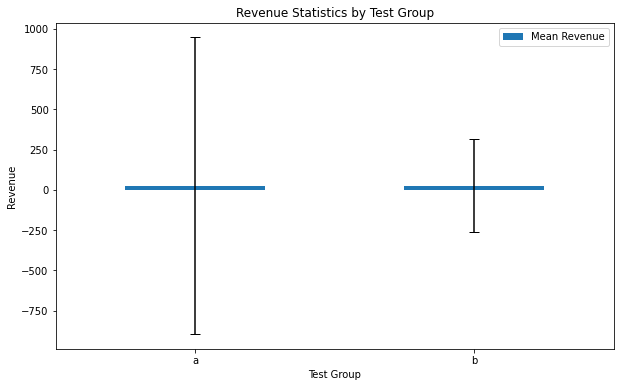

In [87]:
# Визуализируем данные с помощью bar plot
group_stats.plot(kind='bar', y='mean', yerr='std', capsize=5, figsize=(10, 6))
plt.title('Revenue Statistics by Test Group')
plt.xlabel('Test Group')
plt.ylabel('Revenue')
plt.xticks(rotation=0)
plt.legend(['Mean Revenue', 'Standard Deviation'])
plt.show()

1. Средний доход в тестовой группе (26.75) немного выше, чем в контрольной группе (25.41).
2. Однако стандартное отклонение в контрольной группе (920.77) значительно выше, чем в тестовой группе (287.32), что может указывать на большую вариабельность данных в контрольной группе.
3. Максимальный доход в контрольной группе составляет 37 433, в то время как в тестовой группе он составляет 4 000. Это может указывать на наличие крупных значений дохода в контрольной группе.

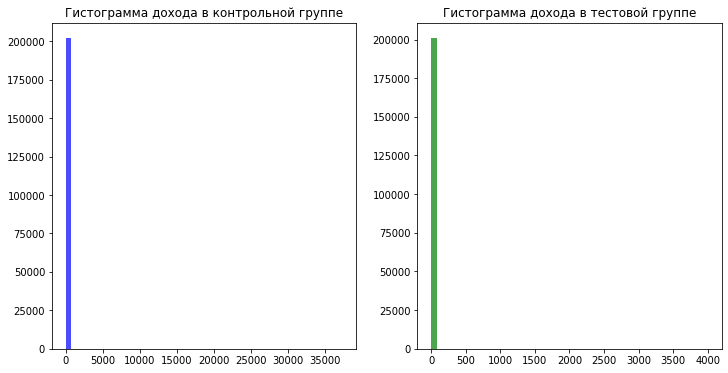

In [108]:
# Разделяем данные на контрольную и тестовую группы
revenue_control = df[df['testgroup'] == 'a']['revenue']
revenue_test = df[df['testgroup'] == 'b']['revenue']

# Строим гистограммы
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(revenue_control, bins=50, color='blue', alpha=0.7)
plt.title('Гистограмма дохода в контрольной группе')

plt.subplot(1, 2, 2)
plt.hist(revenue_test, bins=50, color='green', alpha=0.7)
plt.title('Гистограмма дохода в тестовой группе')

plt.show()

Возможно, что эксперимент был проведён не совсем корректно. Пользователи в разных группах имеют разные уровни оплаты, и скорее всего, разделение на группы было сделано неправильно.

Чтобы сравнить средние значения двух групп, мы можем использовать t-тест для независимых выборок. Этот тест предполагает, что данные имеют нормальное распределение, но его можно использовать и в случаях, когда это предположение не выполняется, если объемы выборки достаточно велики (как минимум 30 наблюдений в каждой группе, а у нас намного больше).

In [112]:
# Группировка данных по testgroup
group_a = df[df['testgroup'] == 'a']['revenue'].values
group_b = df[df['testgroup'] == 'b']['revenue'].values

# Выполнение t-теста
tstat, pvalue = ttest_ind(group_a, group_b)

print(f'T-статистика: {tstat}, p-значение: {pvalue}')

T-статистика: -0.6242026493616787, p-значение: 0.532494858971837


Гипотезы:
Н0 - разичий в группах A и B нет
Н1 - разичия в группах A и B есть

1. T-статистика равна -0.6242, что означает, что средние значения между группами A и B различаются на 0.6242 стандартных отклонения. Отрицательное значение указывает на то, что среднее значение в группе A меньше, чем в группе B.

2. P-значение составляет 0.5325, что означает, что вероятность получить такие или еще более экстремальные различия между группами случайно равна 53.25%. Обычно, если p-значение больше уровня значимости (обычно 0.05), то нет оснований отвергнуть нулевую гипотезу о равенстве средних значений.

На основании полученного p-значения, нет достаточных доказательств для того, чтобы отвергнуть нулевую гипотезу о том, что средние значения выручки в группах A и B одинаковы.

In [116]:
# Также проверим предположение о том, что распределение ненормальное, другим способом:  

control = df[df['testgroup'] == "a"]
test = df[df['testgroup'] == "b"]

In [117]:
scipy.stats.normaltest(control.revenue) 

NormaltestResult(statistic=585152.7312728433, pvalue=0.0)

In [118]:
scipy.stats.normaltest(test.revenue)

NormaltestResult(statistic=326622.39540856465, pvalue=0.0)

На основании результатов теста на нормальность (normaltest) для групп A и B, можно сделать следующие выводы:

1. Для группы A (control) значение статистики теста равно 585152.73, а p-значение равно 0.0. Это означает, что распределение данных по выручке в группе A статистически значимо отличается от нормального распределения.

2. Для группы B (test) значение статистики теста равно 326622.40, а p-значение также равно 0.0. Это указывает на то, что распределение данных по выручке в группе B также статистически значимо отличается от нормального распределения.

Исходя из результатов теста на нормальность, можно сделать вывод, что данные о выручке в обеих группах не имеют нормальное распределение. 

In [151]:
# Рассчитайте общую выручку для каждой группы теста:
revenue_per_group = df.groupby('testgroup')['revenue'].sum()

# Рассчитайте количество уникальных пользователей в каждой группе теста:
users_per_group = df.groupby('testgroup')['user_id'].nunique()

# Рассчитайте ARPU для каждой группы теста:
ARPU_per_group = revenue_per_group / users_per_group
ARPU_per_group

testgroup
a    25.413720
b    26.751287
dtype: float64

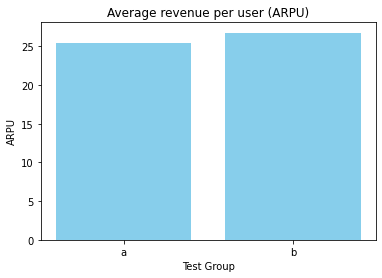

In [154]:
# Создание столбчатой диаграммы для ARPU
plt.bar(ARPU_per_group.index, ARPU_per_group.values, color='skyblue')
plt.xlabel('Test Group')
plt.ylabel('ARPU')
plt.title('Average revenue per user (ARPU)')
plt.show()

Можно сделать следующие выводы: 
 
1. ARPU для тестовой группы (26.75) выше, чем для контрольной группы (25.41). Это может указывать на то, что пользователи из тестовой группы в среднем приносят больше дохода по сравнению с пользователями из контрольной группы. 
 
2. Разница между ARPU групп a и b несущественна. Возможно, различия в поведении пользователей не являются статистически значимыми или требуют более детального анализа.

In [149]:
# Отфильтруtv датафрейм, чтобы оставить только строки с ненулевой выручкой (платящих пользователей):
paying_users_df = df[df['revenue'] > 0]

# Рассчитаем общую выручку для каждой группы теста:
revenue_per_group = paying_users_df.groupby('testgroup')['revenue'].sum()

# Рассчитаем количество уникальных платящих пользователей в каждой группе теста:
paying_users_per_group = paying_users_df.groupby('testgroup')['user_id'].nunique()

# Рассчитаем ARPPU для каждой группы теста:
ARPPU_per_group = revenue_per_group / paying_users_per_group

ARPPU_per_group

testgroup
a    2663.998444
b    3003.658172
dtype: float64

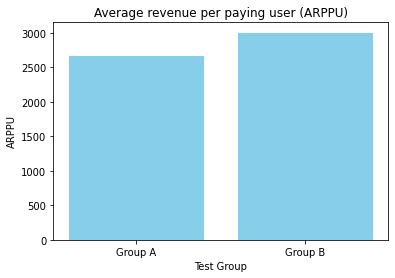

In [150]:
# Визуализируем метрику ARPPU:
import matplotlib.pyplot as plt

plt.bar(ARPPU_per_group.index, ARPPU_per_group.values, color='skyblue')
plt.xlabel('Test Group')
plt.ylabel('ARPPU')
plt.title('Average revenue per paying user (ARPPU)')
plt.xticks(df_grouped.index, ['Group A', 'Group B'])
plt.show()

Исходя из предоставленных данных, можно сделать следующие выводы:
1. ARPPU (Average Revenue Per Paying User) для тестовой группы (3003.66) выше, чем для контрольной группы (2663.99). Это может указывать на то, что пользователи из тестовой группы совершают в среднем более крупные покупки по сравнению с пользователями из контрольной группы.
2. Разница между ARPPU групп a и b несущественна. Возможно, различия в поведении пользователей не являются статистически значимыми или требуют более детального анализа.

ВЫВОДЫ:
    
Из проведенного анализа данных A/B теста можно сделать вывод, что хотя ARPU в тестовой группе оказался выше на 5% по сравнению с контрольной, статистически значимых различий между группами в доходности пользователей не обнаружено. 

Данные о выручке в обеих группах не имеют нормальное распределение, что может указывать на особенности поведения пользователей или на некорректное разделение на группы. 

Дополнительные тесты могут помочь понять причины этих различий, так как невозможно однозначно определить наиболее эффективный набор предложений, поскольку полученные данные выглядят некорректными из-за неравномерного распределения пользователей.